In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import torch
import torch.nn as nn 
import torchvision
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.models import vgg16
from catboost import CatBoostClassifier
from torchvision import datasets
from torch.utils.data import DataLoader, Subset, ConcatDataset


import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import PIL
from PIL import Image

from IPython.display import clear_output
from tqdm.auto import tqdm
import sys
import os
import shutil

#### File I'll use to complete full training of model:

#### First, let's upload the images:

#### ImageFolder sorts by default as I understood

In [2]:
base_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

base_transform_64 = transforms.Compose([transforms.Resize((64, 64)),
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_from_torch = transforms.Compose([transforms.Resize((64, 64)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

transform_from_torch_224 = transforms.Compose([transforms.Resize((224, 224)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

base_augmentation = transforms.Compose([
            transforms.Lambda(lambda img: img.crop((0, 0, 256, 256))),
            transforms.Resize((64, 64)),
            transforms.ToTensor(), 
            transforms.RandomHorizontalFlip(p=1),
            transforms.ColorJitter(brightness=.5, hue=.3),
            # transforms.RandomCrop(size=(64, 64)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

base_augmentation_224 = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(), 
                                    transforms.RandomHorizontalFlip(p=0.75),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

base_base_augmentation = transforms.Compose([transforms.Resize((64, 64)),
                                    transforms.ToTensor(), 
                                    transforms.RandomHorizontalFlip(p=0.75),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

left_upper_corner_transfrom = transforms.Compose([
            transforms.Lambda(lambda img: img.crop((0, 0, 200, 200))),
                    transforms.Resize((64, 64)),
                                    transforms.ToTensor(), 
                                    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
])

base_augmentation_no_norm = transforms.Compose([
            transforms.Lambda(lambda img: img.crop((0, 0, 200, 200))),
            transforms.Resize((64, 64)),
            transforms.ToTensor(), 
            transforms.RandomHorizontalFlip(p=1),
            transforms.ColorJitter(brightness=.5, hue=.3),
            # transforms.RandomCrop(size=(64, 64)),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

In [3]:
def get_dataloaders(transform = base_transform_64, 
                    augmentation = base_augmentation,
                    path_first = './data/class1',
                      path_second = './data/class2', 
                      root_dir = "./data" , 
                      train_size = 0.7, val_size = 0.15, batch_size = 4, difference = 7500):

    first_class_paths = os.listdir(path_first)
    second_class_paths = os.listdir(path_second)

    size_from_first = int(len(first_class_paths)*1)
    size_from_second = int(len(second_class_paths)*1)

    indoor_outdoor_dataset = ImageFolder(root=root_dir, transform=transform)
    indoor_outdoor_dataset_augmented = ImageFolder(root=root_dir, transform=augmentation)

    indoor_dataset = Subset(indoor_outdoor_dataset, range(0, size_from_first))
    outdoor_dataset = Subset(indoor_outdoor_dataset, range(len(first_class_paths), len(first_class_paths) + size_from_second - 1))
    outdoor_dataset_augmented = Subset(indoor_outdoor_dataset_augmented,
                                       range(len(first_class_paths), len(first_class_paths) + difference))

    full_data = ConcatDataset([indoor_dataset, outdoor_dataset, outdoor_dataset_augmented])

    train_size = int(train_size * len(full_data))  # 70% for train
    val_size = int(val_size * len(full_data))   # 15% for validation
    test_size = len(full_data) - train_size - val_size  # Rest for the test

    train_dataset, val_dataset, test_dataset = random_split(full_data, [train_size, val_size, test_size], 
                                                            generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    return train_loader, val_loader, test_loader



In [ ]:
# train_loader, val_loader, test_loader = get_dataloaders(transform=transform_from_torch_224,
#                                                          augmentation=base_augmentation_224,
#                                                          batch_size=32)

# For 0.5 0.5 Network

# train_loader, val_loader, test_loader = get_dataloaders(transform=base_transform_64,
#                                                          augmentation=base_augmentation,
#                                                          batch_size=250, difference=12000) # Best Right Now

train_loader, val_loader, test_loader = get_dataloaders(transform=left_upper_corner_transfrom,
                                                         augmentation=base_augmentation_no_norm,
                                                         batch_size=128, difference=12000)

In [78]:
def compare_length_datasets(dataloader):

    '''Function that calcs number of labels presented in dataset'''
    
    labels_total = np.array([])

    for batch in tqdm(dataloader):

        images, labels = batch

        labels = labels.cpu().numpy()
        labels_total = np.append(labels_total, labels)
    
    return labels_total

labels_array = compare_length_datasets(train_loader)

  0%|          | 0/595 [00:00<?, ?it/s]

In [79]:
labels_array_test, labels_array_val = compare_length_datasets(test_loader), compare_length_datasets(val_loader)

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

In [80]:
def get_classes_info(array):
    '''Prints some info about data'''  

    print(f"Number of images in dataset: {len(array)}")
    print(f"Number of classes presented in data: {len(np.unique(array))}")

    print()
    
    mask_class_1 = np.where(array ==  0)
    mask_class_2 = np.where(array == 1)

    first_class = array[mask_class_1]
    second_class = array[mask_class_2]

    print(f"Number of images by class 0: {len(first_class)}")
    print(f"Number of images by class 1: {len(second_class)}")

    print()

    if len(first_class) == len(second_class):
        print("No disbalance in data")
        print()
    
    else:
        if len(first_class) > len(second_class):
            print("Disbalance: number in first is greater")
        else:
            print("Disbalance: number in second is greater")
        print(f"Difference: {abs(len(first_class) - len(second_class))}")


get_classes_info(labels_array)

Number of images in dataset: 152083
Number of classes presented in data: 2

Number of images by class 0: 75273
Number of images by class 1: 76810

Disbalance: number in second is greater
Difference: 1537


In [81]:
get_classes_info(labels_array_test)

Number of images in dataset: 32590
Number of classes presented in data: 2

Number of images by class 0: 16137
Number of images by class 1: 16453

Disbalance: number in second is greater
Difference: 316


In [82]:
get_classes_info(labels_array_val)

Number of images in dataset: 32589
Number of classes presented in data: 2

Number of images by class 0: 16235
Number of images by class 1: 16354

Disbalance: number in second is greater
Difference: 119


In [77]:
def print_info(train_loader, val_loader, test_loader):

    print(f"Length of train_loader: {len(train_loader)}")
    print(f"Length of val_loader: {len(val_loader)}")
    print(f"length of test_loader: {len(test_loader)}")

print_info(train_loader, val_loader, test_loader)

Length of train_loader: 595
Length of val_loader: 128
length of test_loader: 128


#### Ok, finally we acquired that. Let's show how the images look like (64 x 64, 0.5, 0.5):

tensor([1, 1, 1, 1])


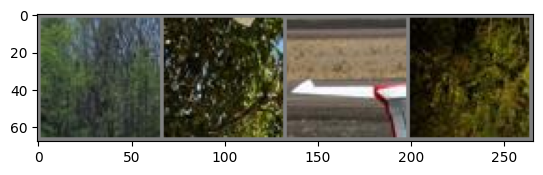

In [57]:
def matplotlib_imshow(img, one_channel=False):

    if one_channel:
        img = img.mean(dim=0)
    img = img * 0.5 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)
print(labels)

In [172]:
print_info(train_loader, val_loader, test_loader)

Length of train_loader: 4491
Length of val_loader: 963
length of test_loader: 963


#### Check batches:

In [173]:
def check_after_dataload(dataloader, break_iter = True):
    
    for images, labels in dataloader:
        print(images.size(), labels)
        if break_iter:
            break
        
check_after_dataload(train_loader)

torch.Size([32, 3, 224, 224]) tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0])


In [95]:
writer = SummaryWriter('runs/running_indoor_outdoor_model_double_convolution')

#### Class DoubleConv (64 x 64, 0.5, 0.5):

In [5]:
class CNNIndoorOutdoorDoubleConv(nn.Module):
    
    def __init__(self):
        super(CNNIndoorOutdoorDoubleConv, self).__init__()
        self.convolution_layers = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_image):
        x = self.convolution_layers(input_image)
        x = x.view(x.size(0), -1)  
        x = self.fully_connected_layers(x)
        
        return x

In [6]:
modelCNNIndoorOutdoorDoubleConv = CNNIndoorOutdoorDoubleConv()  
optimizer = optim.Adam(modelCNNIndoorOutdoorDoubleConv.parameters(), lr=0.001) 
criterion = nn.BCELoss()

In [7]:
optimizer_adadelta = optim.Adadelta(modelCNNIndoorOutdoorDoubleConv.parameters(), lr=0.0005) 

In [8]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Save model state"""
    torch.save(state, filename)

def load_checkpoint(modelCNN, optimizer, filename='checkpoint.pth'):
    
    checkpoint = torch.load(filename)
    modelCNN.load_state_dict(checkpoint['model_state_dict']) 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    epoch = checkpoint['epoch'] 
    loss = checkpoint['loss'] 
    accuracy = checkpoint['accuracy']  
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    return epoch, loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, file, device = 'cpu', num_epochs=10, 
                first_flag = True,
                optimizer_new_flag = False, optimizer_new = optimizer_adadelta):
    if first_flag:
        best_val_acc = 0.0
        epoch_last = 0
    else:
        epoch_last, loss, accuracy = load_checkpoint(model, optimizer, file)
        if optimizer_new_flag:
            optimizer = optimizer_new

        best_val_acc = accuracy
    
    model = model.to(device)

    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels.view(labels.size(0), -1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs.view(-1) > 0.5).long() 
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        writer.add_scalar('Loss/train', train_loss, epoch + epoch_last)
        writer.add_scalar('Accuracy/train', train_acc, epoch + epoch_last)
        writer.add_scalar('Loss/val', val_loss, epoch + epoch_last)
        writer.add_scalar('Accuracy/val', val_acc, epoch + epoch_last)
        

        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }
            save_checkpoint(checkpoint, file)
            
    
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(labels.size(0), -1))
            running_loss += loss
            predicted = (outputs.view(-1) > 0.5).long() 
            # print(predicted)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(test_loader)  
    accuracy = correct / total 
    
    print(f'Accuracy on test set: {accuracy:.4f}')
    print(f'Average Loss on test set: {avg_loss:.4f}')

    return avg_loss, accuracy

def predict_model(model, test_loader, device):
    model.eval()

    predicted_array = []
    labels_array = []
    # correct = 0
    # total = 0
    # running_loss = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device).float().numpy()
            outputs = model(inputs)
            # loss = criterion(outputs, labels.view(labels.size(0), -1))
            # running_loss += loss
            predicted = (outputs.view(-1) > 0.5).long().numpy()
            # print(predicted)
            predicted_array.append(predicted)
            labels_array.append(labels)
            # print(predicted)
            # correct += (predicted == labels).sum().item()
            # total += labels.size(0)
            # if i > threshold_test:
            #     break

    # avg_loss = running_loss / len(test_loader)  
    # accuracy = correct / total 
    
    # print(f'Accuracy on test set: {accuracy:.4f}')
    # print(f'Average Loss on test set: {avg_loss:.4f}')

    accuracy = accuracy_score(y_pred=np.concatenate(predicted_array), y_true=np.concatenate(labels_array))
    classification_report_task = classification_report(y_pred=np.concatenate(predicted_array), y_true=np.concatenate(labels_array))
    confusion_matrix_task = confusion_matrix(y_pred=np.concatenate(predicted_array), y_true=np.concatenate(labels_array))

    return classification_report_task, confusion_matrix_task, accuracy

In [9]:
load_checkpoint(modelCNNIndoorOutdoorDoubleConv, optimizer, filename='double_conv_model.pth')

Checkpoint loaded. Epoch: 4, Loss: 0.2660682499408722, Accuracy: 0.900808730390724


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_17399/4036010281.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


(4, tensor(0.2661), 0.900808730390724)

#### Start training now (more data):

In [ ]:
train_model(modelCNNIndoorOutdoorDoubleConv, train_loader, val_loader, criterion, optimizer,
             file = 'double_conv_model.pth', num_epochs=3, first_flag=False)

In [162]:
load_checkpoint(modelCNNIndoorOutdoorDoubleConv, optimizer, filename='double_conv_model.pth')

Checkpoint loaded. Epoch: 4, Loss: 0.2660682499408722, Accuracy: 0.900808730390724


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_86693/4226393180.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


(4, tensor(0.2661), 0.900808730390724)

In [125]:
classification_report_task, confusion_matrix_task, accuracy = predict_model(modelCNNIndoorOutdoorDoubleConv, test_loader, 'cpu')

  0%|          | 0/963 [00:00<?, ?it/s]

In [126]:
print(accuracy)

0.9033452419616759


In [127]:
print(classification_report_task)

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91     16203
         1.0       0.92      0.87      0.89     14587

    accuracy                           0.90     30790
   macro avg       0.91      0.90      0.90     30790
weighted avg       0.90      0.90      0.90     30790



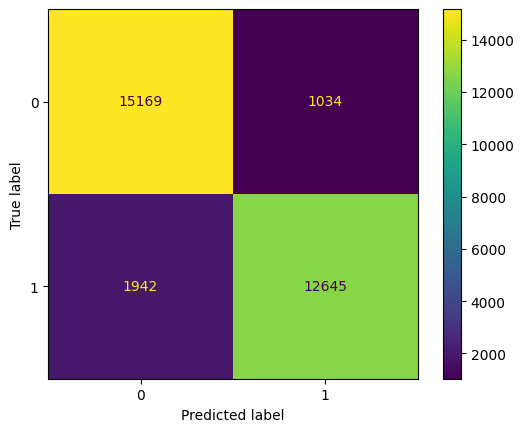

In [128]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_task)
disp.plot()
plt.show()

#### Let's look at the train_loss distrubution (probably, it's actual to filter some samples or augment them):

In [ ]:
def imshow(img, title):
    """image show function"""
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def inference_and_visualize_errors(model, test_loader, device ='cpu'):
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []
    losses = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device).float()

            outputs = model(inputs)
            
            predicted = (outputs > 0.5).float().view(-1)
            loss = criterion(outputs, labels.view(labels.size(0), -1))


            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            losses.append(loss.item())

            for idx in incorrect_indices:
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(predicted[idx].cpu().item())
            

    for i in range(min(10, len(incorrect_images))):
        imshow(incorrect_images[i], f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

        writer.add_image(f'Error_{i}', incorrect_images[i])
        writer.add_text(f'Error_{i}', f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')
    return losses

losses = inference_and_visualize_errors(modelCNNIndoorOutdoorDoubleConv, train_loader)


#### This model is for 64x64 size, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) and without augmentation

#### Next is 64x64, transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) and augmented

#### And plot the distribution of losses via batches:

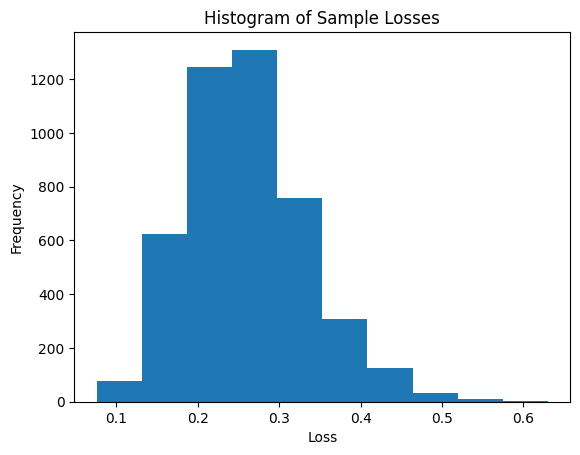

In [132]:
plt.hist(losses)
plt.title('Histogram of Sample Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

#### Augmentated:

In [10]:
class CNNIndoorOutdoorDoubleConvAugmentated(nn.Module):
    
    def __init__(self):
        super(CNNIndoorOutdoorDoubleConvAugmentated, self).__init__()
        self.convolution_layers = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fully_connected_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_image):
        x = self.convolution_layers(input_image)
        # print(x.size())
        x = x.view(x.size(0), -1)  
        x = self.fully_connected_layers(x)
        
        return x

In [11]:
modelCNNIndoorOutdoorDoubleConvAugmentated = CNNIndoorOutdoorDoubleConvAugmentated()  
optimizer = optim.Adam(modelCNNIndoorOutdoorDoubleConvAugmentated.parameters(), lr=0.001) 
criterion = nn.BCELoss()

In [12]:
optimizer = optim.RMSprop(modelCNNIndoorOutdoorDoubleConvAugmentated.parameters(), lr=0.01) 

In [13]:
writer = SummaryWriter('runs/running_indoor_outdoor_model_double_convolution_augmentated')

In [14]:
optimizer_new = optim.Adadelta(modelCNNIndoorOutdoorDoubleConvAugmentated.parameters(), lr=0.01) 

In [59]:
load_checkpoint(modelCNNIndoorOutdoorDoubleConvAugmentated, optimizer, filename='double_conv_model_augmentated.pth')

Checkpoint loaded. Epoch: 15, Loss: 0.21260762214660645, Accuracy: 0.9174261253797293


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_17399/4036010281.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


(15, tensor(0.2126), 0.9174261253797293)

In [110]:
train_model(modelCNNIndoorOutdoorDoubleConvAugmentated, train_loader, val_loader, criterion, optimizer,
             file = 'double_conv_model_augmentated.pth', num_epochs=15, first_flag=False, optimizer_new_flag=True,
             optimizer_new=optimizer_new)

Checkpoint loaded. Epoch: 3, Loss: 0.22058901190757751, Accuracy: 0.915428965344363


/var/folders/8x/8fk55v410t9cm_2bp2lzvrwr0000gn/T/ipykernel_3172/3443766483.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9169
Average Loss on test set: 0.2136
Epoch [1/15], Loss: 0.2183, Accuracy: 0.9182, Val Loss: 0.2136, Val Accuracy: 0.9169
Validation accuracy improved from 0.9154 to 0.9169. Saving model...


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9167
Average Loss on test set: 0.2139
Epoch [2/15], Loss: 0.2171, Accuracy: 0.9185, Val Loss: 0.2139, Val Accuracy: 0.9167


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9164
Average Loss on test set: 0.2148
Epoch [3/15], Loss: 0.2159, Accuracy: 0.9187, Val Loss: 0.2148, Val Accuracy: 0.9164


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9166
Average Loss on test set: 0.2138
Epoch [4/15], Loss: 0.2159, Accuracy: 0.9186, Val Loss: 0.2138, Val Accuracy: 0.9166


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9168
Average Loss on test set: 0.2135
Epoch [5/15], Loss: 0.2158, Accuracy: 0.9192, Val Loss: 0.2135, Val Accuracy: 0.9168


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9168
Average Loss on test set: 0.2133
Epoch [6/15], Loss: 0.2150, Accuracy: 0.9192, Val Loss: 0.2133, Val Accuracy: 0.9168


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9163
Average Loss on test set: 0.2144
Epoch [7/15], Loss: 0.2151, Accuracy: 0.9189, Val Loss: 0.2144, Val Accuracy: 0.9163


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9174
Average Loss on test set: 0.2133
Epoch [8/15], Loss: 0.2146, Accuracy: 0.9195, Val Loss: 0.2133, Val Accuracy: 0.9174
Validation accuracy improved from 0.9169 to 0.9174. Saving model...


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9172
Average Loss on test set: 0.2140
Epoch [9/15], Loss: 0.2137, Accuracy: 0.9197, Val Loss: 0.2140, Val Accuracy: 0.9172


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9172
Average Loss on test set: 0.2134
Epoch [10/15], Loss: 0.2129, Accuracy: 0.9194, Val Loss: 0.2134, Val Accuracy: 0.9172


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9174
Average Loss on test set: 0.2144
Epoch [11/15], Loss: 0.2133, Accuracy: 0.9197, Val Loss: 0.2144, Val Accuracy: 0.9174


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9171
Average Loss on test set: 0.2130
Epoch [12/15], Loss: 0.2122, Accuracy: 0.9196, Val Loss: 0.2130, Val Accuracy: 0.9171


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9174
Average Loss on test set: 0.2122
Epoch [13/15], Loss: 0.2120, Accuracy: 0.9195, Val Loss: 0.2122, Val Accuracy: 0.9174


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9169
Average Loss on test set: 0.2140
Epoch [14/15], Loss: 0.2122, Accuracy: 0.9201, Val Loss: 0.2140, Val Accuracy: 0.9169


  0%|          | 0/595 [00:00<?, ?it/s]

Accuracy on test set: 0.9174
Average Loss on test set: 0.2126
Epoch [15/15], Loss: 0.2116, Accuracy: 0.9200, Val Loss: 0.2126, Val Accuracy: 0.9174
Validation accuracy improved from 0.9174 to 0.9174. Saving model...


#### Evaluate model (This was trained not with additional augmented 2nd class samples):

In [71]:
cp, cm, acc = predict_model(modelCNNIndoorOutdoorDoubleConvAugmentated, test_loader, 'cpu')

  0%|          | 0/131 [00:00<?, ?it/s]

In [152]:
print(acc)

0.9156182878183492


In [153]:
print(cp)

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92     16238
         1.0       0.95      0.88      0.91     16352

    accuracy                           0.92     32590
   macro avg       0.92      0.92      0.92     32590
weighted avg       0.92      0.92      0.92     32590



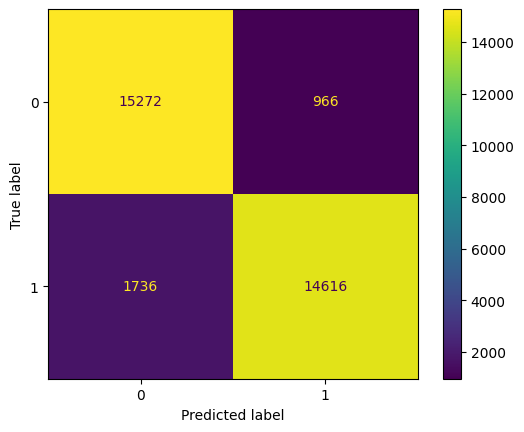

In [125]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Left upper corner train (Try):

In [164]:
class CNNIndoorOutdoorDoubleConvAugmentatedCrop(CNNIndoorOutdoorDoubleConvAugmentated):
    
    def __init__(self):
        super(CNNIndoorOutdoorDoubleConvAugmentatedCrop, self).__init__()
       

In [165]:
cropped_model_new = CNNIndoorOutdoorDoubleConvAugmentatedCrop()
optimizer = optim.Adam(cropped_model_new.parameters(), lr=0.0005) 
criterion = nn.BCELoss()
writer = SummaryWriter('runs/running_indoor_outdoor_model_double_convolution_augmentated_cropped_new')
optimizer_new = optim.Adadelta(cropped_model_new.parameters(), lr=0.01) 

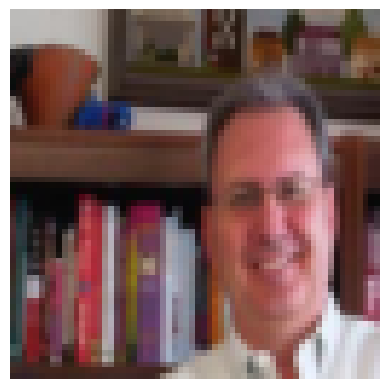

In [116]:
import torch
from torchvision import transforms
from PIL import Image

image = Image.open('/Users/chervonikov_alexey/Desktop/projects/Technopark_Autumn_2024/Нейронки/third_lesson_cnn/HomeWorkFolder/data/class1/00000001_11016.jpg')
# image.show()

cropped_image_tensor = left_upper_corner_transfrom(image)

image_tensor_numpy = cropped_image_tensor.permute(1, 2, 0).numpy()

plt.imshow(image_tensor_numpy)
plt.axis('off') 
plt.show()


In [163]:
train_model(cropped_model_new, train_loader, val_loader, criterion, optimizer,
             file = 'double_conv_model_augmentated_croped_new.pth', num_epochs=35, first_flag=True, optimizer_new_flag=False,
             optimizer_new=optimizer_new)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8268
Average Loss on test set: 0.3896
Epoch [1/35], Loss: 0.4560, Accuracy: 0.7853, Val Loss: 0.3896, Val Accuracy: 0.8268
Validation accuracy improved from 0.0000 to 0.8268. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8506
Average Loss on test set: 0.3459
Epoch [2/35], Loss: 0.3744, Accuracy: 0.8373, Val Loss: 0.3459, Val Accuracy: 0.8506
Validation accuracy improved from 0.8268 to 0.8506. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8658
Average Loss on test set: 0.3156
Epoch [3/35], Loss: 0.3343, Accuracy: 0.8585, Val Loss: 0.3156, Val Accuracy: 0.8658
Validation accuracy improved from 0.8506 to 0.8658. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8717
Average Loss on test set: 0.3121
Epoch [4/35], Loss: 0.3084, Accuracy: 0.8721, Val Loss: 0.3121, Val Accuracy: 0.8717
Validation accuracy improved from 0.8658 to 0.8717. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8853
Average Loss on test set: 0.2766
Epoch [5/35], Loss: 0.2883, Accuracy: 0.8808, Val Loss: 0.2766, Val Accuracy: 0.8853
Validation accuracy improved from 0.8717 to 0.8853. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8805
Average Loss on test set: 0.2864
Epoch [6/35], Loss: 0.2757, Accuracy: 0.8876, Val Loss: 0.2864, Val Accuracy: 0.8805


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8944
Average Loss on test set: 0.2640
Epoch [7/35], Loss: 0.2621, Accuracy: 0.8943, Val Loss: 0.2640, Val Accuracy: 0.8944
Validation accuracy improved from 0.8853 to 0.8944. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8958
Average Loss on test set: 0.2582
Epoch [8/35], Loss: 0.2494, Accuracy: 0.8995, Val Loss: 0.2582, Val Accuracy: 0.8958
Validation accuracy improved from 0.8944 to 0.8958. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8963
Average Loss on test set: 0.2573
Epoch [9/35], Loss: 0.2366, Accuracy: 0.9048, Val Loss: 0.2573, Val Accuracy: 0.8963
Validation accuracy improved from 0.8958 to 0.8963. Saving model...


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8959
Average Loss on test set: 0.2666
Epoch [10/35], Loss: 0.2246, Accuracy: 0.9106, Val Loss: 0.2666, Val Accuracy: 0.8959


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8943
Average Loss on test set: 0.2618
Epoch [11/35], Loss: 0.2148, Accuracy: 0.9140, Val Loss: 0.2618, Val Accuracy: 0.8943


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8869
Average Loss on test set: 0.2775
Epoch [12/35], Loss: 0.2008, Accuracy: 0.9192, Val Loss: 0.2775, Val Accuracy: 0.8869


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8893
Average Loss on test set: 0.2924
Epoch [13/35], Loss: 0.1871, Accuracy: 0.9257, Val Loss: 0.2924, Val Accuracy: 0.8893


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8907
Average Loss on test set: 0.2951
Epoch [14/35], Loss: 0.1735, Accuracy: 0.9305, Val Loss: 0.2951, Val Accuracy: 0.8907


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8881
Average Loss on test set: 0.3148
Epoch [15/35], Loss: 0.1601, Accuracy: 0.9362, Val Loss: 0.3148, Val Accuracy: 0.8881


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8905
Average Loss on test set: 0.3192
Epoch [16/35], Loss: 0.1460, Accuracy: 0.9419, Val Loss: 0.3192, Val Accuracy: 0.8905


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8869
Average Loss on test set: 0.3831
Epoch [17/35], Loss: 0.1348, Accuracy: 0.9469, Val Loss: 0.3831, Val Accuracy: 0.8869


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8878
Average Loss on test set: 0.4049
Epoch [18/35], Loss: 0.1243, Accuracy: 0.9511, Val Loss: 0.4049, Val Accuracy: 0.8878


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8829
Average Loss on test set: 0.4423
Epoch [19/35], Loss: 0.1133, Accuracy: 0.9557, Val Loss: 0.4423, Val Accuracy: 0.8829


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8836
Average Loss on test set: 0.4668
Epoch [20/35], Loss: 0.1044, Accuracy: 0.9594, Val Loss: 0.4668, Val Accuracy: 0.8836


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8842
Average Loss on test set: 0.5042
Epoch [21/35], Loss: 0.0951, Accuracy: 0.9633, Val Loss: 0.5042, Val Accuracy: 0.8842


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8882
Average Loss on test set: 0.5107
Epoch [22/35], Loss: 0.0906, Accuracy: 0.9653, Val Loss: 0.5107, Val Accuracy: 0.8882


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8892
Average Loss on test set: 0.5386
Epoch [23/35], Loss: 0.0827, Accuracy: 0.9686, Val Loss: 0.5386, Val Accuracy: 0.8892


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8861
Average Loss on test set: 0.4986
Epoch [24/35], Loss: 0.0796, Accuracy: 0.9703, Val Loss: 0.4986, Val Accuracy: 0.8861


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8854
Average Loss on test set: 0.4811
Epoch [25/35], Loss: 0.0761, Accuracy: 0.9713, Val Loss: 0.4811, Val Accuracy: 0.8854


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8855
Average Loss on test set: 0.5436
Epoch [26/35], Loss: 0.0696, Accuracy: 0.9742, Val Loss: 0.5436, Val Accuracy: 0.8855


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8861
Average Loss on test set: 0.6709
Epoch [27/35], Loss: 0.0668, Accuracy: 0.9751, Val Loss: 0.6709, Val Accuracy: 0.8861


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8861
Average Loss on test set: 0.5836
Epoch [28/35], Loss: 0.0662, Accuracy: 0.9760, Val Loss: 0.5836, Val Accuracy: 0.8861


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8875
Average Loss on test set: 0.5882
Epoch [29/35], Loss: 0.0609, Accuracy: 0.9776, Val Loss: 0.5882, Val Accuracy: 0.8875


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8827
Average Loss on test set: 0.6041
Epoch [30/35], Loss: 0.0598, Accuracy: 0.9783, Val Loss: 0.6041, Val Accuracy: 0.8827


  0%|          | 0/1189 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

Accuracy on test set: 0.8801
Average Loss on test set: 0.6309
Epoch [31/35], Loss: 0.0583, Accuracy: 0.9788, Val Loss: 0.6309, Val Accuracy: 0.8801


  0%|          | 0/1189 [00:00<?, ?it/s]

#### Overfitting started from 9 epoch... But on train it grows

Коэффициенты полинома: [ 3.14285714e+00  1.11022302e-16 -5.71428571e-01]


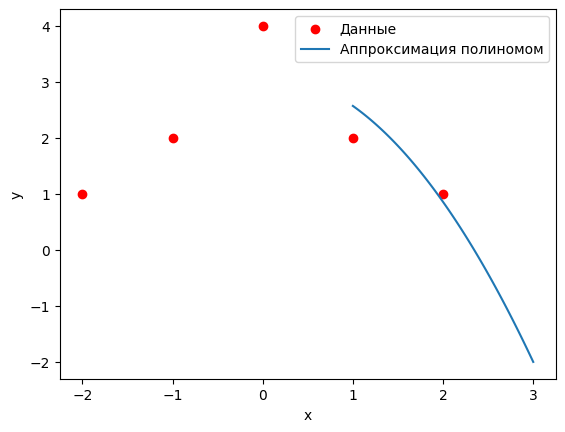

In [1]:
import numpy as np

# Данные
x = np.array([-2, -1, 0, 1, 2])
y = np.array([1, 2, 4, 2, 1])

# Степень полинома
degree = 2

# Создаем матрицу X для полинома степени degree
X = np.column_stack([x**i for i in range(degree + 1)])

# Вычисляем коэффициенты полинома
coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

# Выводим коэффициенты
print("Коэффициенты полинома:", coefficients)

# Функция для вычисления значений полинома
def polynomial(x, coefficients):
    return sum(coef * x**i for i, coef in enumerate(coefficients))

# Проверка аппроксимации
x_test = np.linspace(1, 3, 100)
y_test = polynomial(x_test, coefficients)

# Визуализация
import matplotlib.pyplot as plt

plt.scatter(x, y, color='red', label='Данные')
plt.plot(x_test, y_test, label='Аппроксимация полиномом')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
